<a href="https://colab.research.google.com/github/ayaelsayed25/Face-Recognition/blob/main/Face_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LDA Transformation**

In [ ]:
def LDA(train_data, train_labels):
  #Construct the D matrix of shape: (40, 200, 10304) so that Di in D is for the ith class (class-specific subset)
  D = np.hstack((train_data,train_labels[:,None]))
  D = D[D[:, -1].argsort()]
  D = np.split(D[:,:-1], np.unique(D[:, -1], return_index=True)[1][1:])
  overall_mean = np.mean(train_data,axis = 0) #Mean vector for the sample data
  print(np.shape(D))
  B_sum = np.zeros((n_of_features,n_of_features)) #B matrix
  S_sum = np.zeros((n_of_features,n_of_features)) #S matrix : Covariance matrix
  for d in D : #d is the class-specific subset
    mean = np.mean(d,axis = 0) #class mean
    n = np.shape(d)[0] #number of samples in the class
    mean_difference = np.subtract(mean,overall_mean)
    mean_difference = mean_difference.reshape(n_of_features,1)
    mean_difference_t = mean_difference.T
    B_sum +=  n * np.dot(mean_difference,mean_difference_t) #B = Σ 𝑛𝑘 (𝜇𝑘 − 𝜇)(𝜇𝑘 − 𝜇)𝑇
    Z = np.subtract(d,mean) #center class matrix
    S_sum += np.dot(Z.T,Z) #S = Σ (Zi)𝑇(Zi)
  product = np.dot(np.linalg.inv(S_sum),B_sum) # product = (S^-1)B
  eigen_values,eigen_vectors = np.linalg.eigh(product)
  #sort eigen values and the corresponding eigen vectors
  idx = eigen_values.argsort()[::-1]
  eigen_values = eigen_values[idx]
  eigen_vectors = eigen_vectors[:,idx]
  return eigen_values, eigen_vectors

# **PCA transformation**

In [ ]:
def PCA(train_data):
  mean=np.mean(train_data, axis=0) #computing the mean
  z=train_data-mean  #centeralization of the data
  cov_Matrix=np.cov(z.T) #getting the covariance matrix 
  print(np.shape(cov_Matrix))
  eigen_values,eigen_vectors = np.linalg.eigh(cov_Matrix) #getting the eigen values and vectors 
  idx = eigen_values.argsort()[::-1]   
  eigen_values = eigen_values[idx] # ordering the eigen values
  eigen_vectors = eigen_vectors[:,idx]
  eigen_values_sum=np.sum(eigen_values)
  return eigen_values, eigen_vectors, eigen_values_sum

In [ ]:
#determine how many columns will be taken from the eigen vectors
def PCA_alpha(alpha, eigen_vectors, eigen_values, eigen_values_sum, train_data, test_data):
  r=0
  ratio=0
  while ratio<alpha :
    ratio=ratio+eigen_values[r]/eigen_values_sum
    r=r+1
  projection_matrix_pca= eigen_vectors[:, 0:r]  #projection_matrix
  print(np.shape(projection_matrix_pca))
  train_data_pca =np.dot(train_data,projection_matrix_pca)
  test_data_pca=np.dot(test_data,projection_matrix_pca)
  return train_data_pca,test_data_pca

**Evaluation of PCA for different alpha values**

In [ ]:
def PCA_evaluate(train_data, test_data, train_labels, test_labels):
  alpha=[0.8,0.85,0.9,0.95]
  # alpha=[0.85]
  best_accuracy_of_k=[]
  eigen_values, eigen_vectors, eigen_values_sum = PCA(train_data)
  for a in alpha :
    train_pca,test_pca=PCA_alpha(a, eigen_vectors, eigen_values, eigen_values_sum, train_data, test_data)
    acc,k=knn_train(train_pca,train_labels,test_pca,test_labels)
    # print("Alpha = ", a)
    # print("Best accuracy = ", max(acc), " Best k = ", k[acc.index(max(acc))])
    #plot(acc,k, "K-value", "Accuracy")
    best_accuracy_of_k.append(max(acc))
  #plot(best_accuracy_of_k,alpha, "Alpha", "Best Accuracy")
  return best_accuracy_of_k

**PCA With Cross Validation**

In [ ]:
def PCA_cross_valid(train_data, test_data, train_labels, test_labels):
  alpha=[0.8,0.85,0.9,0.95]
  best_accuracy_of_k=[]
  eigen_values, eigen_vectors, eigen_values_sum = PCA(train_data)
  for a in alpha :
    train_pca,test_pca=PCA_alpha(a, eigen_vectors, eigen_values, eigen_values_sum)
    k,acc=knn_cross_valid(train_pca,train_labels,test_pca,test_labels)
    best_accuracy_of_k.append(max(acc))
    print("Alpha = ", a)
    print("Best accuracy = ", max(acc))
  return max(best_accuracy_of_k)

# **KNN Model**

**Training**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
def knn_train(train_data, train_labels, test_data, test_labels):
  acc = []
  k = [1, 3, 5, 7]
  max_acc = 0
  for i in k:
    classifier = KNeighborsClassifier(n_neighbors = i, metric = 'minkowski', p = 2) #P = 2 : Euclidean distance
    classifier.fit(train_data, train_labels)
    y_pred = classifier.predict(test_data)
    accuracy = accuracy_score(test_labels,y_pred)
    acc.append(accuracy)
  return acc, k

**KNN With Cross Validation**

In [ ]:
from sklearn.model_selection import cross_val_score, cross_val_predict
def knn_cross_valid(train_data, train_labels, test_data, test_labels):
  k = [1]
  k_scores = []
  acc = []
  for i in k:
    classifier = KNeighborsClassifier(n_neighbors = i, metric = 'minkowski', p = 2) #P = 2 : Euclidean distance
    scores = cross_val_score(classifier, train_data, train_labels, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())
    predictions = cross_val_predict(classifier, test_data, test_labels, cv=5)
    accuracy = metrics.r2_score(test_labels, predictions)
    acc.append(accuracy)
  return k_scores, acc

**Plot Accuracy Vs. K**

In [ ]:
import matplotlib.pyplot as plt
def plot(acc, k, x_axis, y_axis):
  plt.figure(figsize=(10,6))
  plt.plot(k,acc,color = 'blue',linestyle='dashed', 
          marker='o',markerfacecolor='red', markersize=10)
  plt.title(str(y_axis) + " vs. " +  str(x_axis))
  plt.xlabel(x_axis)
  plt.ylabel(y_axis)

# **Faces Dataset Preparation**

In [ ]:
from skimage.io import imread
import numpy as np
from zipfile import ZipFile
!unzip archive.zip -d dataset

Archive:  archive.zip
replace dataset/README? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import os
dataset = []
labels = []
for filename in os.listdir('dataset'): #loop through the 40 subject folders in dataset folder
  if(filename[0] == 's'):
    id = int(filename[1:]) #subject's id
    for image in os.listdir('dataset/'+filename): #loop through each pgm image in the subject's folder
      img = imread('dataset/'+filename+'/'+image) #read the image
      # img = np.append(img,id)
      labels.append(id) #add the subject's id to labels
      dataset.append(np.ndarray.flatten(img)) #flatten the image (convert it into a vector of 10304 values) and append it to the dataset
dataset = np.array(dataset) 
labels = np.array(labels)
print(np.shape(dataset)) #(400, 10304) : 400 images and 10304 attributes
print(np.shape(labels)) #(400) : a label for each image

(400, 10304)
(400,)


**Train-test Split: Odd Rows For Train Data and Even Ones For Test Data**

In [ ]:
train_data = dataset[1::2] #odd rows for train data
train_labels = labels[1::2] 
test_data = dataset[::2] #even rows for test data
test_labels = labels[::2]
n_of_features = np.shape(train_data)[1]
print(np.shape(train_data))

(200, 10304)


#**Bonus part**

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
sss.get_n_splits(dataset, labels)
for train_index, test_index in sss.split(dataset, labels):
  X_train, X_test = dataset[train_index], dataset[test_index]
  y_train, y_test = labels[train_index], labels[test_index]

#check the counts of different labels
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))
unique, counts = np.unique(y_test, return_counts=True)
print(dict(zip(unique, counts)))
train_data, test_data, train_labels, test_labels = X_train, X_test, y_train, y_test
n_of_features = np.shape(train_data)[1]

{1: 3, 2: 3, 3: 3, 4: 3, 5: 3, 6: 3, 7: 3, 8: 3, 9: 3, 10: 3, 11: 3, 12: 3, 13: 3, 14: 3, 15: 3, 16: 3, 17: 3, 18: 3, 19: 3, 20: 3, 21: 3, 22: 3, 23: 3, 24: 3, 25: 3, 26: 3, 27: 3, 28: 3, 29: 3, 30: 3, 31: 3, 32: 3, 33: 3, 34: 3, 35: 3, 36: 3, 37: 3, 38: 3, 39: 3, 40: 3}


#**Applying LDA & KNN On The Faces Dataset**

In [ ]:
eigen_values, eigen_vectors = LDA(train_data, train_labels)
projection_matrix = eigen_vectors[:,:39] #construct projection matrix

Save Projection matrix in a text file

In [ ]:
np.savetxt('test.txt',projection_matrix , delimiter=',')

Upload projection matrix

In [ ]:
from numpy import genfromtxt
projection_matrix = genfromtxt('test.txt', delimiter=',')
print(type(projection_matrix))
print(np.shape(projection_matrix))

Projection of Data into The 39 Dimensions

In [ ]:
#Data : 200 * 10304,  U : 10304 * 39 
train_data_LDA = np.dot(train_data, projection_matrix)
test_data_LDA = np.dot(test_data, projection_matrix)
print(np.shape(train_data_LDA), np.shape(test_data_LDA))

(280, 39) (120, 39)


**LDA Evaluation**

Maximum_accuracy 0.9416666666666667
Best K value 1


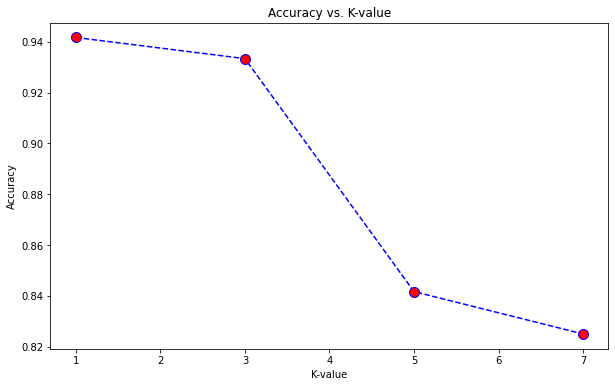

In [ ]:
acc, k = knn_train(train_data_LDA, train_labels, test_data_LDA, test_labels)
print("Maximum_accuracy", max(acc))
print("Best K value", k[acc.index(max(acc))])
#plot accuracy vs K
plot(acc, k, "K-value", "Accuracy")

#**Applying PCA & KNN On The Faces Dataset**

In [ ]:
accur = PCA_evaluate(train_data, test_data, train_labels, test_labels)
print(max(accur))

#**Face vs Non-face Images**

**Convert Image to Pmg**

In [ ]:
import cv2
import numpy as np
def convert_image(filename):
    x = cv2.imread(filename, cv2.IMREAD_GRAYSCALE) #convert to pgm
    x = cv2.resize(x, (112, 92)) 
    npfeatures = np.array(x)
    return npfeatures

**Construct Non-face Dataset**

In [ ]:
from zipfile import ZipFile
!unzip images.zip -d new
import os
non_face = []
for filename in os.listdir('new'): 
  img = convert_image("new/" + filename) #convert to pgm
  non_face.append(np.ndarray.flatten(img)) #flatten the image (convert it into a vector of 10304 values) and append it to the dataset
non_face = np.array(non_face) 
print(np.shape(non_face)) #(400, 10304) : 400 images and 10304 attributes

In [ ]:
label_ones = np.full(400, 1)
label_zeros = np.full(400, 0)
face = dataset
print(np.shape(face))
print(np.shape(non_face))

(400, 10304)
(400, 10304)


**Train-test Split: 50% For Train Data and 50% For Test Data**

In [ ]:
from sklearn.model_selection import train_test_split
data = np.vstack((face, non_face))
lbls = np.hstack((label_ones, label_zeros))
print(np.shape(lbls))
data_train, data_test, label_train, label_test = train_test_split(data, lbls, test_size=0.5, random_state =42)
print(np.shape(data_train), np.shape(data_test), np.shape(label_train), np.shape(label_test))

#**Applying LDA & PCA On Face vs Non-face Dataset**

**Determining The Dominant Number of Eigenvectors For The Face vs Non-face Dataset**

In [ ]:
accuracy = []
for i in range(1, 200) :
  projection_matrix = eigen_vecs[:,:i] #construct projection matrix
  data_train_LDA = np.dot(data_train, projection_matrix)
  data_test_LDA = np.dot(data_test, projection_matrix)
  ac, k = knn_train(data_train_LDA, label_train, data_test_LDA, label_test)
  accuracy.append(max(ac))
  print(i)

[0.785, 0.975, 0.9875, 0.995, 0.9975, 0.9975, 0.995, 0.995, 0.995, 0.995, 0.9925, 0.9925, 0.995, 0.9975, 0.9975, 0.9975, 0.995, 0.995, 0.9975, 0.9975, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9975, 0.9975, 0.9975, 0.9975, 0.995, 0.995, 0.995, 0.9975, 0.9975, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.9975, 0.9975, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975, 0.9975,

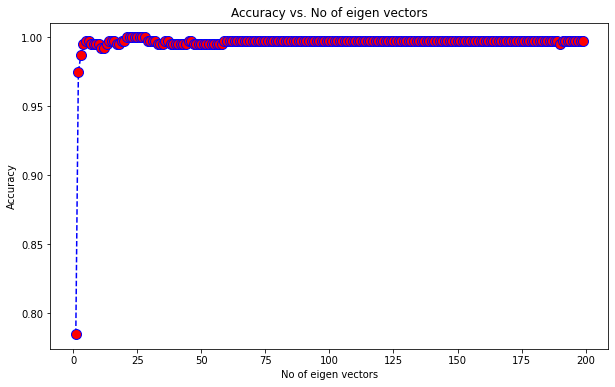

In [ ]:
values = list(range(1, 200))
np.savetxt('accuracy.txt',accuracy , delimiter=',')
plot(accuracy, values,"No of eigen vectors", "Accuracy")
print(accuracy)
print("Max accuracy: ", max(accuracy))
print("Corresponding number of eigen vectors", accuracy.index(max(accuracy)))

**Applying LDA ON Face vs. Non-face Dataset While Changing The Number of Non-face Images**

In [ ]:
def LDA_no_non_face(faces, non_faces):
  accuracy = []
  num = []
  for i in range(100, 401, 100) :
    data = np.vstack((faces, non_faces[0:i, :]))
    label_ones = np.full(400, 1)
    label_zeros = np.full(i, 0)
    lbls = np.hstack((label_ones, label_zeros))
    data_train, data_test, label_train, label_test = train_test_split(data, lbls, test_size=0.5, random_state =42) #train-test split
    eigen_vals, eigen_vecs = LDA(data_train, label_train)
    projection_matrix = eigen_vecs[:,:20] #construct projection matrix
    data_train_LDA = np.dot(data_train, projection_matrix)
    data_test_LDA = np.dot(data_test, projection_matrix)
    ac, k = knn_train(data_train_LDA, label_train, data_test_LDA, label_test) #knn training
    accuracy.append(max(ac))
    print(np.shape(data_train), np.shape(data_test), np.shape(data_test), np.shape(label_test))
    num.append(i)
  plot(accuracy, num, "Number of non-face images", "Accuracy")
  

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(2,)
(250, 10304) (250, 10304) (250, 10304) (250,)
(2,)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(300, 10304) (300, 10304) (300, 10304) (300,)
(2,)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(350, 10304) (350, 10304) (350, 10304) (350,)
(2,)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(400, 10304) (400, 10304) (400, 10304) (400,)


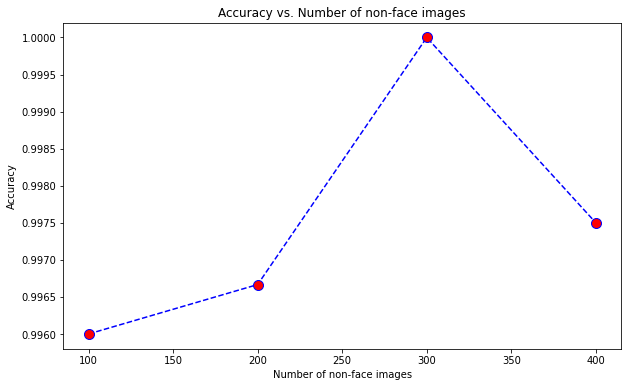

In [ ]:
LDA_no_non_face(face, non_face)


**Applying PCA ON Face vs. Non-face Dataset While Changing The Number of Non-face Images**

In [ ]:
def PCA_no_non_face(faces, non_faces):
  accuracy = []
  num = []
  for i in range(20, 401, 20) :
    data = np.vstack((faces, non_faces[0:i, :]))
    label_ones = np.full(400, 1)
    label_zeros = np.full(i, 0)
    lbls = np.hstack((label_ones, label_zeros))
    data_train, data_test, label_train, label_test = train_test_split(data, lbls, test_size=0.5, random_state =42)
    ac = PCA_evaluate(data_train, data_test, label_train, label_test)
    accuracy.append(max(ac))
    num.append(i)
  plot(accuracy, num, "Number of non-face images", "Accuracy")

In [ ]:
PCA_no_non_face(face, non_face)

#Visualization Using Decision Trees

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(data_train, label_train)
tree.plot_tree(clf)

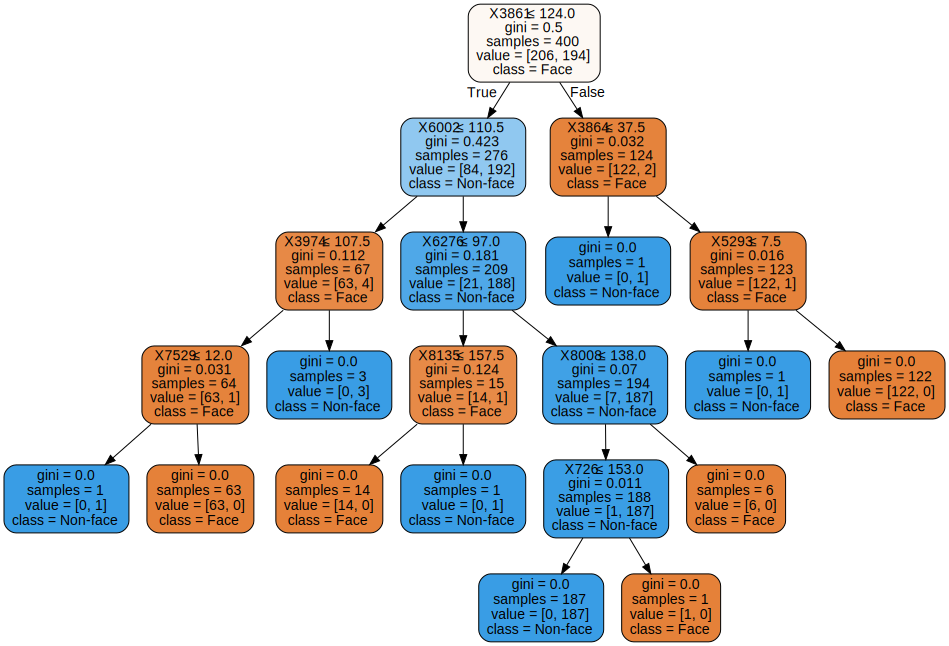

In [ ]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
dot_data = tree.export_graphviz(clf, out_file=None, 
                    class_names=["Face", "Non-face"],  
                    filled=True, rounded=True,  
                    special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

In [ ]:
from sklearn import metrics
y_predict = clf.predict(data_test)
print("Accuracy:",metrics.accuracy_score(label_test, y_predict))

Accuracy: 0.9


#**Sheet 4: Question 2**

**Training Model**

In [ ]:
def naive_bayes_classification(train_data, train_labels):
  #Construct the D matrix of shape: (40, 7, 10304) so that Di in D is for the ith class (class-specific subset)
  D = np.hstack((train_data,train_labels[:,None]))
  D = D[D[:, -1].argsort()]
  D = np.split(D[:,:-1], np.unique(D[:, -1], return_index=True)[1][1:])
  num_of_classes = np.shape(D)[0]
  size = np.shape(D)[1] * np.shape(D)[0]
  M = np.empty((num_of_classes, n_of_features))
  p_c = np.empty((num_of_classes))
  var = np.empty((num_of_classes, n_of_features))
  Z = D 
  i = 0
  for Di in D:
    ni = np.shape(Di)[0] #number of samples in the class Di
    p_c[i] = ni / size #append P(ci)
    Mi = np.mean(Di ,axis = 0) #Mean vector
    M[i] = Mi #append to matrix
    Zi = Di - Mi #centered matrix
    vari = np.empty((n_of_features))
    for j in range(n_of_features):
      variance = float((((Zi[:, j]).T).dot(Zi[:,j])) / ni)
      vari[j] = variance
    var[i] = vari
    i += 1
  return p_c, M, var

In [ ]:
p_c, M, var = naive_bayes_classification(train_data, train_labels)
print(np.shape(p_c), np.shape(M), np.shape(var))

(40,) (40, 10304) (40, 10304)


**Testing Model**

In [ ]:
import math
def testing(p_c, M, var, test_data, test_labels):
  num_of_classes = np.shape(p_c)[0]
  accuracy = 0
  count = 0
  ys = []
  for x in test_data:
    probs = np.empty((num_of_classes))
    for i in range(num_of_classes):
      product = 1.0
      for j in range(n_of_features):
        numerator = np.exp((-1/2)*((x[j]-M[i][j])**2) / (2 * var[i][j]))
        denominator = np.sqrt(2 * np.pi * var[i][j])
        prob = numerator / denominator
      probs[i] = p_c[i] * prob
    y = np.argmax(probs)
    ys.append(y)
    true_label =  test_labels[count]
    if y == true_label : accuracy += 1
    count += 1
  return accuracy / np.shape(test_labels)[0], ys


In [ ]:
from sklearn.metrics import confusion_matrix
accuracy, ys = testing(p_c, M, var, test_data, test_labels)
mat = confusion_matrix(test_labels, ys)
print("Accuracy = ", accuracy)
print("Confusion Matrix : ")
print(mat)

Accuracy =  0.008333333333333333
Confusion Matrix : 
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 0 0]]


**Applying PCA on Data**

In [ ]:
n_of_features = 40
eigen_values, eigen_vectors, _ = PCA(train_data)
projection_matrix = eigen_vectors[:,:n_of_features]
train_data_PCA = np.dot(train_data, projection_matrix)
test_data_PCA = np.dot(test_data, projection_matrix)
print(np.shape(train_data_PCA), np.shape(test_data_PCA))

(10304, 10304)
(280, 40) (120, 40)


In [ ]:
p_c, M, var = naive_bayes_classification(train_data_PCA, train_labels)
print(np.shape(p_c), np.shape(M), np.shape(var))
accuracy_PCA, ys_PCA= testing(p_c, M, var, test_data_PCA, test_labels)
print("Accuracy = ", accuracy_PCA)
mat_PCA = confusion_matrix(test_labels, ys_PCA)
print("Confusion Matrix : ")
print(mat_PCA)

(40,) (40, 40) (40, 40)
Accuracy =  0.016666666666666666
Confusion Matrix : 
[[0 2 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 ...
 [0 2 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]]
